In [26]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import glob

# Suppose all your CSVs are inside "stock_data/" directory
file_paths = glob.glob("dataset/*.csv")

dfs = []
for path in file_paths:
    # Extract stock name from filename (e.g., AAPL.csv -> AAPL)
    stock_name = path.split("\\")[-1].replace(".csv", "")
    
    df = pd.read_csv(path, parse_dates=["timestamp"])
    
    # Rename to match AutoGluon expected schema
    df = df.rename(columns={"close": "target"})
    
    # Add item_id column for stock
    df["item_id"] = stock_name
    
    dfs.append(df[["item_id", "timestamp", "target"]])

# Concatenate all stocks into one dataframe
all_data = pd.concat(dfs).reset_index(drop=True)

# Convert into TimeSeriesDataFrame
ts_data = TimeSeriesDataFrame.from_data_frame(
    all_data,
    id_column="item_id",
    timestamp_column="timestamp"
)

print(ts_data.head())


                    target
item_id timestamp         
AALI    2001-04-16     547
        2001-04-17     524
        2001-04-18     524
        2001-04-19     500
        2001-04-20     452


In [27]:
# Hitung jumlah timestamp per saham
counts = ts_data.groupby("item_id").size()

# Ambil saham yang punya >= 30 data
valid_items = counts[counts >= 1500].index

# Filter dataframe hanya untuk saham valid
ts_data_filtered = ts_data[ts_data.index.get_level_values("item_id").isin(valid_items)]

print("Sebelum:", ts_data.index.get_level_values("item_id").nunique(), "saham")
print("Sesudah:", ts_data_filtered.index.get_level_values("item_id").nunique(), "saham")



Sebelum: 824 saham
Sesudah: 506 saham


In [28]:
# Daftar saham yang masih ada setelah filter
filtered_items = ts_data_filtered.index.get_level_values("item_id").unique()

print("Jumlah saham:", len(filtered_items))
print("Daftar saham:", filtered_items.tolist())


Jumlah saham: 506
Daftar saham: ['AALI', 'ABBA', 'ABDA', 'ABMM', 'ACES', 'ACST', 'ADES', 'ADHI', 'ADMF', 'ADMG', 'ADRO', 'AGII', 'AGRO', 'AGRS', 'AHAP', 'AIMS', 'AISA', 'AKKU', 'AKPI', 'AKRA', 'AKSI', 'ALDO', 'ALKA', 'ALMI', 'ALTO', 'AMAG', 'AMFG', 'AMIN', 'AMRT', 'ANJT', 'ANTM', 'APEX', 'APIC', 'APII', 'APLI', 'APLN', 'ARGO', 'ARII', 'ARNA', 'ARTA', 'ARTI', 'ARTO', 'ASBI', 'ASDM', 'ASGR', 'ASII', 'ASJT', 'ASMI', 'ASRI', 'ASRM', 'ASSA', 'ATIC', 'AUTO', 'BABP', 'BACA', 'BAJA', 'BALI', 'BAPA', 'BATA', 'BAYU', 'BBCA', 'BBHI', 'BBKP', 'BBLD', 'BBMD', 'BBNI', 'BBRI', 'BBRM', 'BBTN', 'BBYB', 'BCAP', 'BCIC', 'BCIP', 'BDMN', 'BEKS', 'BEST', 'BFIN', 'BGTG', 'BHIT', 'BIKA', 'BIMA', 'BINA', 'BIPI', 'BIPP', 'BIRD', 'BISI', 'BJBR', 'BJTM', 'BKDP', 'BKSL', 'BKSW', 'BLTA', 'BLTZ', 'BMAS', 'BMRI', 'BMSR', 'BMTR', 'BNBA', 'BNBR', 'BNGA', 'BNII', 'BNLI', 'BOGA', 'BOLT', 'BPFI', 'BPII', 'BRAM', 'BRMS', 'BRNA', 'BRPT', 'BSDE', 'BSIM', 'BSSR', 'BSWD', 'BTEK', 'BTEL', 'BTON', 'BTPN', 'BUDI', 'BUKK', 'BULL',

In [29]:
dataframed = pd.DataFrame({
    'daftar_saham': filtered_items.to_list()
})

dataframed.to_csv('daftar_saham.csv', index=False)

In [30]:
prediction_length = 1200
train_data, test_data = ts_data_filtered.train_test_split(prediction_length)

In [31]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length, eval_metric='MAE', freq='1D').fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=6000,  # time limit in seconds
    enable_ensemble=False,
)

Frequency '1D' stored as 'D'
Beginning AutoGluon training... Time limit = 6000s
AutoGluon will save models to 'd:\Project iseng\StockAI\backend StockAI\modeling StockAI\AutogluonModels\ag-20250908_044919'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          1
Memory Avail:       2.75 GB / 11.78 GB (23.3%)
Disk Space Avail:   179.05 GB / 237.13 GB (75.5%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': MAE,
 'freq': 'D',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1200,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_ever

In [32]:
scores = predictor.evaluate(test_data, metrics=['MASE','MAPE','RMSE','SMAPE'])
print(scores)

data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]


{'MASE': -24.338095981721054, 'MAPE': -12.394906652996466, 'RMSE': np.float64(-91491.38940825948), 'SMAPE': -0.5523895162861165}


In [41]:
from autogluon.timeseries import TimeSeriesPredictor

predictor = TimeSeriesPredictor.load("AutogluonModels/ag-20250908_044919")  
# replace with your actual save path


Loading predictor from path d:\Project iseng\StockAI\backend StockAI\modeling StockAI\AutogluonModels\ag-20250908_044919


In [42]:
# Directly predict future values for all series
forecast = predictor.predict(ts_data)


data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]


In [45]:
import os

# Convert forecast to pandas DataFrame
df = forecast.to_data_frame().reset_index()

# Make sure output directory exists
os.makedirs("forecast_result", exist_ok=True)

# Loop through each item_id
for item in df["item_id"].unique():
    item_df = df[df["item_id"] == item][["timestamp", "mean"]]
    item_df.to_csv(f"forecast_result/{item}_forecast.csv", index=False)


In [39]:
# Inspect forecast for one stock
stock_id = ts_data.item_ids[0]  # or pick manually
forecast_stock = forecast.loc[stock_id]
print(forecast_stock.head())  # shows next 30 timestamps

                   mean          0.1          0.2          0.3          0.4  \
timestamp                                                                     
2023-01-07  8087.535156  7774.543945  7903.443359  7981.307617  8042.720215   
2023-01-08  8079.225586  7722.900391  7879.045898  7960.862305  8031.556152   
2023-01-09  8077.478027  7681.188477  7854.636719  7951.703613  8023.370117   
2023-01-10  8079.604492  7685.513672  7843.642578  7940.526367  8019.671875   
2023-01-11  8059.351562  7656.332031  7823.804688  7922.856445  7996.607910   

                    0.5          0.6          0.7          0.8          0.9  
timestamp                                                                    
2023-01-07  8087.535156  8127.263184  8170.544922  8235.006836  8345.327148  
2023-01-08  8079.225586  8128.860352  8180.725098  8259.779297  8386.105469  
2023-01-09  8077.478027  8126.064453  8188.417969  8264.718750  8411.484375  
2023-01-10  8079.604492  8130.899902  8201.662109  8287.

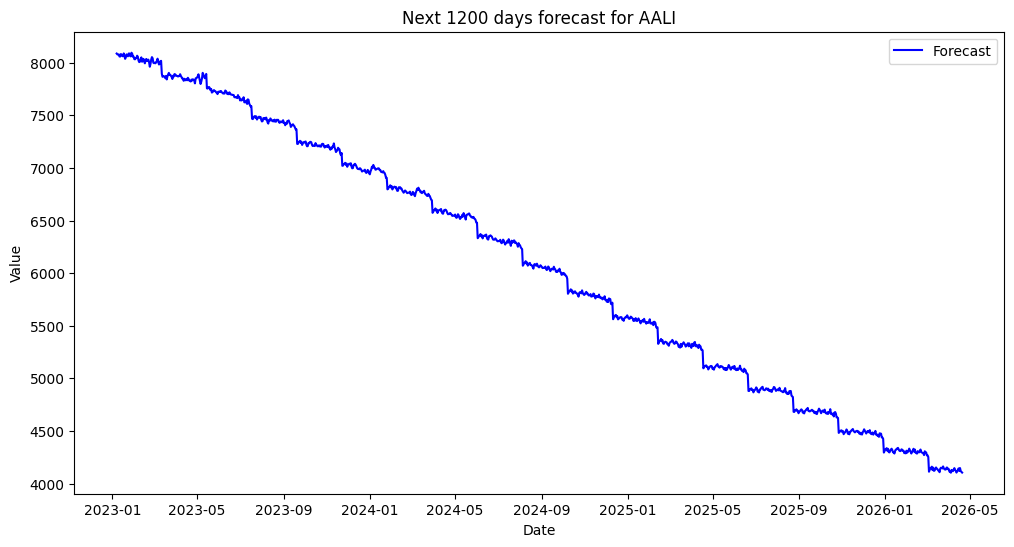

In [40]:
import matplotlib.pyplot as plt

history = ts_data.loc[stock_id]

plt.figure(figsize=(12,6))
plt.plot(forecast_stock.index, forecast_stock["mean"], label="Forecast", color="blue")

plt.title(f"Next {len(forecast_stock)} days forecast for {stock_id}")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()
